# 光谱解混
## 添加必要库，定义路径

In [40]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal
from scipy.optimize import nnls
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.signal import argrelextrema
# from scipy.spatial.distance import cdist

# 定义数据目录
directories = [
    "../data/library/txt/",
    "../data/library/csv/",
    "../data/test/single/txt/",
    "../data/test/single/csv/",
    "../data/test/multi/txt/",
    "../data/test/multi/csv/",
    "../data/library/txt_full/",
    "../data/library/csv_full/"
    ]


## 建立光谱库

In [41]:
def create_library(directory):
    library = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            mine_name = filename.split(".")[0]
            with open(os.path.join(directory, filename), 'r') as f:
                df = pd.read_csv(f)
                library[mine_name] = df
    return library

spectrum_lib = create_library(directories[1])
spectrum_lib2 = create_library(directories[7])
test_lib = create_library(directories[3])
multi_lib=create_library(directories[5])

## 定义光谱绘制函数

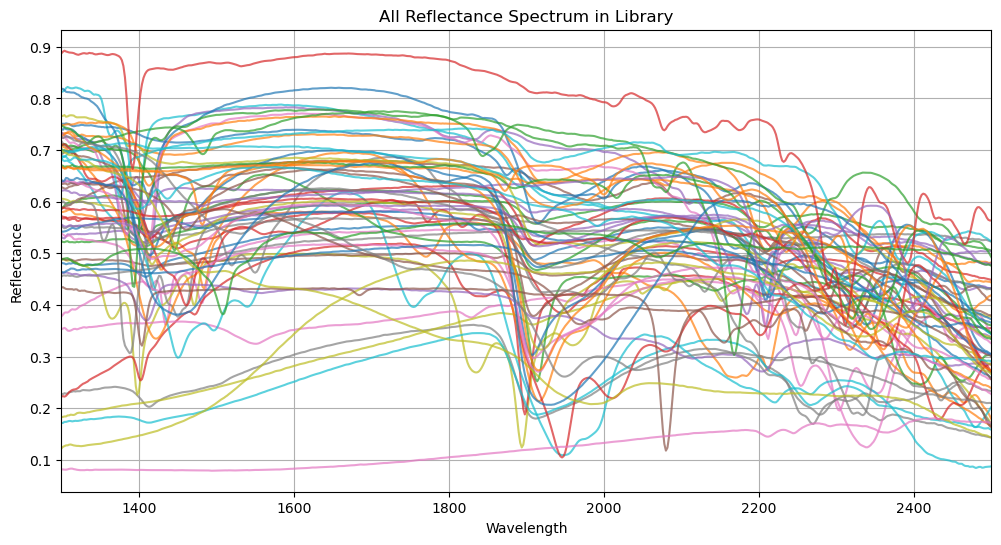

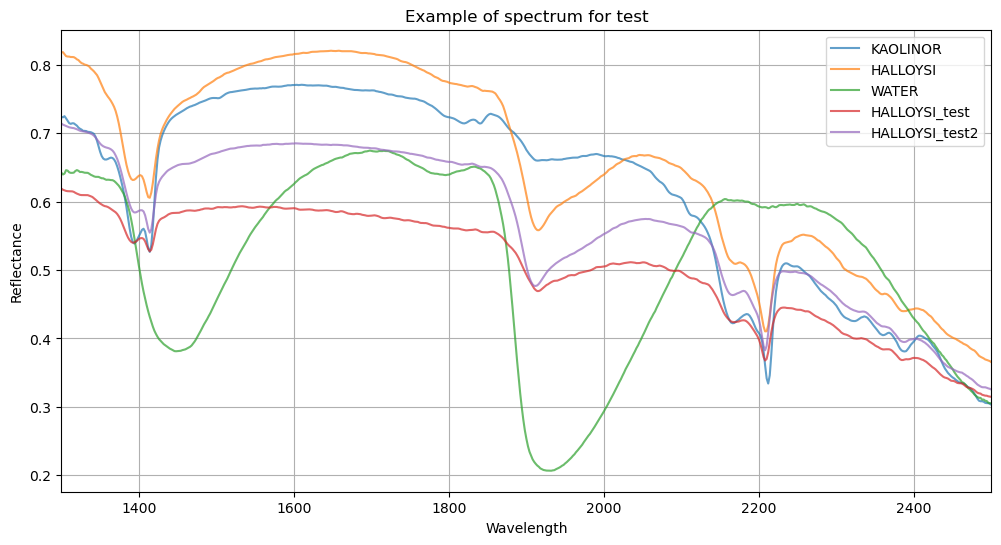

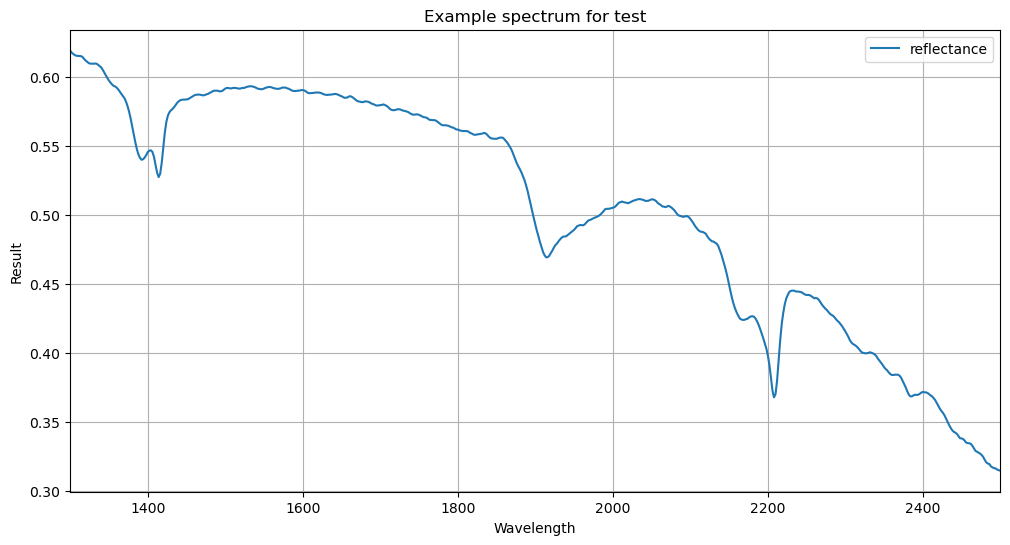

In [42]:
def plot_spectrums(spectrums, attr='reflectance', legend_added=True, title='Spectrum'):
    # 设置图表大小
    plt.figure(figsize=(12, 6))
    plot_ylabel=attr.capitalize()
    # 绘制图表
    for name, df in spectrums.items():
        plt.plot(df['wavelength'], df[attr], label=name, alpha=0.7)
    # 设置图表数据范围、横纵坐标标签、标题、图例、网格
    plt.xlim(1300, 2500)
    plt.xlabel('Wavelength')
    plt.ylabel(plot_ylabel)
    plt.title(title)
    if legend_added:
        plt.legend()
    plt.grid(True)
    plt.show()

# 根据attrs绘制光谱图，attrs默认为全部属性
def plot_spectrum(spectrum, attrs=None, title='Spectrum'):
    plt.figure(figsize=(12, 6))
    # attr为所有属性列表（除了wavelength）
    attrs = spectrum.columns.tolist() if attrs is None else attrs
    attrs.remove('wavelength')
    for attr in attrs:
        plt.plot(spectrum['wavelength'], spectrum[attr], label=attr)
    plt.xlim(1300, 2500)
    plt.xlabel('Wavelength')
    plt.ylabel('Result')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
        

test_target_spectrum = {
    'KAOLINOR':spectrum_lib['KAOLINOR'],
    'HALLOYSI':spectrum_lib['HALLOYSI'],
    'WATER':spectrum_lib['WATER2'],
    'HALLOYSI_test':pd.read_csv('../data/test/single/csv/gb81078-HALL.csv'),
    'HALLOYSI_test2':pd.read_csv('../data/test/single/csv/mottled white and iron stained-HALL.csv'),
}

plot_spectrums(spectrum_lib,'reflectance',False,'All Reflectance Spectrum in Library')
plot_spectrums(test_target_spectrum,'reflectance',title='Example of spectrum for test')
plot_spectrum(test_target_spectrum['HALLOYSI_test'],title='Example spectrum for test')

## TEST

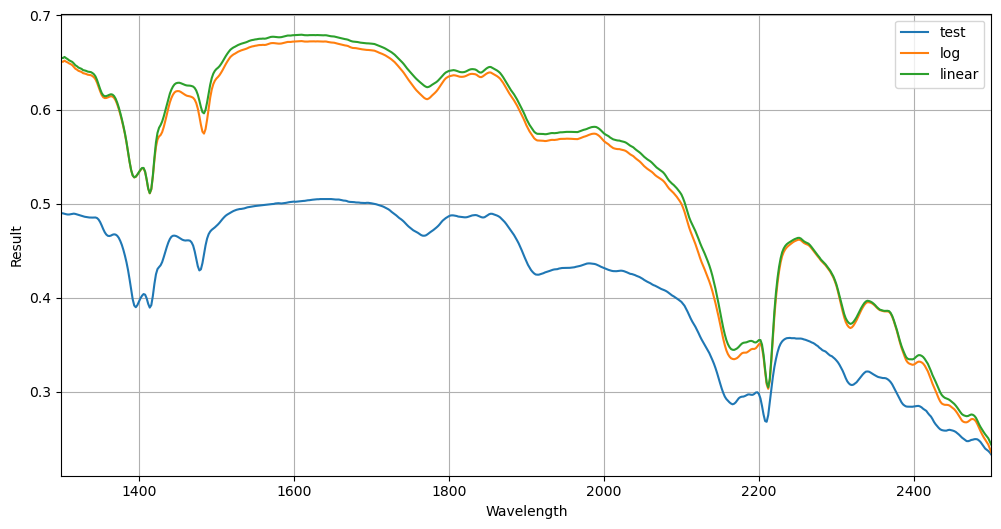

In [43]:
a=0.48
b=0.52
al=spectrum_lib['ALUNITE2']['reflectance']
ka=spectrum_lib['KAOLINOR']['reflectance']
test=multi_lib['al40ka60']['reflectance']
fitted_log=10**((a*np.log10(al)+b*np.log10(ka))/np.log10(10))
fitted_linear=(a*al+b*ka)/(a+b)

plt.figure(figsize=(12, 6))
plt.plot(multi_lib['al40ka60']['wavelength'], test, label='test')
plt.plot(multi_lib['al40ka60']['wavelength'], fitted_log, label='log')
plt.plot(multi_lib['al40ka60']['wavelength'], fitted_linear, label='linear')
plt.xlim(1300, 2500)
plt.xlabel('Wavelength')
plt.ylabel('Result')
plt.legend()
plt.grid(True)
plt.show()

## 光谱预处理

### 对数化

In [44]:
def log_transform(spectrum, attr='reflectance'):
    y = spectrum[attr]
    y_new = np.log10(y)
    spectrum['log'] = y_new
    return y_new

### 基线校正

In [45]:
def baseline_correction(spectrum, attr='log', lam=1e5, p=0.01, niter=10):
    y = spectrum[attr]
    y_base = scipy.signal.savgol_filter(y, 51, 3)
    y_new = spectrum['baseline'] =y-y_base
    return y_new

### 归一化

In [46]:
def normalize(spectrum, attr='log'):
    y = spectrum[attr]
    y_new = (y - y.min()) / (y.max() - y.min())
    spectrum['normalized'] = y_new
    return y_new

### 降噪

In [47]:
def denoise(spectrum, attr='log'):
    y = spectrum[attr]
    y_new = scipy.signal.wiener(y, mysize=5)
    spectrum['denoised'] = y_new
    return y_new

In [48]:
def preprocess(spectrum):
    log_transform(spectrum)
    baseline_correction(spectrum)
    normalize(spectrum, 'baseline')
    # denoise(spectrum)
    return spectrum

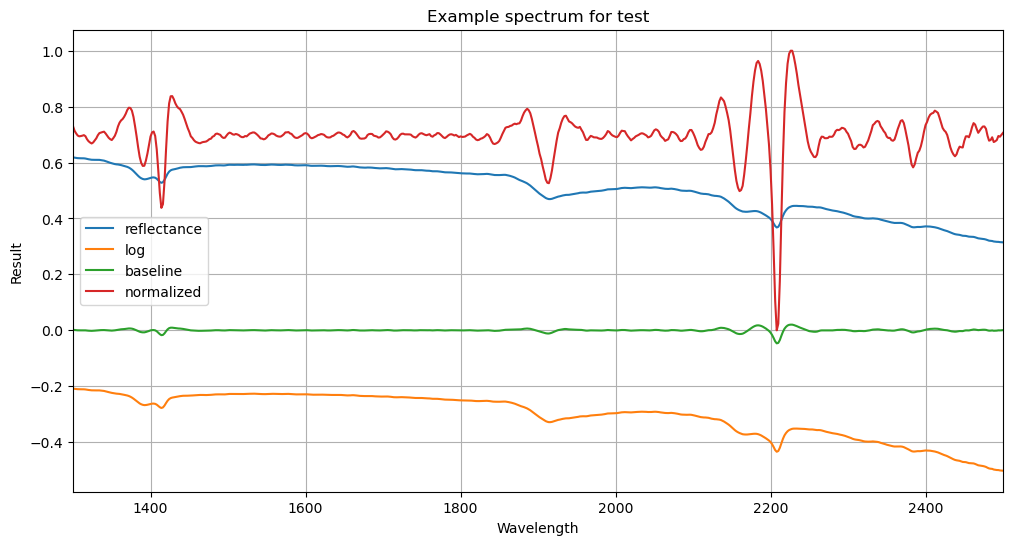

In [49]:
preprocess(test_target_spectrum['HALLOYSI_test'])
plot_spectrum(test_target_spectrum['HALLOYSI_test'],
              # attrs=['log','baseline','normalized','denoised'],
              title='Example spectrum for test')

### 预处理汇总

In [50]:
# 预处理光谱库
def preprocess_library(spectrum_lib):
    for mine_name, df in spectrum_lib.items():
        preprocess(df)

preprocess_library(spectrum_lib)
single_lib=test_lib
preprocess_library(single_lib)
preprocess_library(multi_lib)
preprocess_library(spectrum_lib2)

## 光谱解混

### FSS+线性回归

In [51]:
# import pandas as pd
# import numpy as np
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.linear_model import LinearRegression

# # 光谱库的预处理
# def preprocess_library(spectrum_lib):
#     wavelengths = []
#     reflectances = []
#     labels = []
#     for mine_name, df in spectrum_lib.items():
#         wavelengths.append(df.iloc[:, 0])  # assuming the first column is wavelength
#         reflectances.append(df.iloc[:, 1])  # assuming the second column is reflectance
#         labels.append(mine_name)
#     return np.array(wavelengths), np.array(reflectances), labels

# wavelengths, reflectances, labels = preprocess_library(spectrum_lib)

# # 特征选择
# n_features = 10  # number of features to select
# lr = LinearRegression()
# sfs = SequentialFeatureSelector(lr, n_features_to_select=n_features)
# sfs.fit(wavelengths, reflectances)
# selected_features = sfs.get_support(indices=True)
# # 训练模型
# lr.fit(wavelengths[:, selected_features], reflectances)

### 最小二乘拟合

In [52]:
def get_matrix(spectrum_lib, test_spectrum, attr='normalized'):
    # 从字典中取出所有的光谱数据
    normalized_arrays = [df[attr].values for df in spectrum_lib.values()]
    # 将所有的光谱数据合并成一个矩阵，每一行代表一个光谱数据
    merged_array = np.vstack(normalized_arrays)
    # 将矩阵转置
    transposed_array = merged_array.T
    # 取出测试光谱数据
    test_array = test_spectrum[attr].values
    return transposed_array, test_array


In [53]:

A,y = get_matrix(spectrum_lib, multi_lib['al10ka90'])

# 使用 scipy.optimize.nnls 进行优化
from scipy.optimize import nnls

x, rnorm = nnls(A, y)
# 输出优化结果，即各个成分的相对丰度
print(len(x))

# 记录丰度大于阈值的成分
components = []
for i, mine_name in enumerate(spectrum_lib.keys()):
    if x[i] > 0.0:
        components.append((mine_name, x[i]))

# 从大到小排序
components.sort(key=lambda x: x[1], reverse=True)
# 归一化
total = sum([abundance for mine_name, abundance in components])
components = [(mine_name, abundance/total) for mine_name, abundance in components]
# 输出结果
for mine_name, abundance in components:
    print(f'{mine_name}: {abundance*100:.2f}%')


63
KAOLINOR: 40.68%
HALLOYSI: 37.23%
NH4ILLIT: 5.68%
ALUNITE2: 5.28%
ANTIGORI: 4.08%
BRUCITE: 2.82%
ANORTHIT: 1.78%
ANDESINE: 1.58%
PYROPHYL: 0.86%


KAOLINOR: 29.23%
TOURMALI: 23.43%
ALUNITE2: 15.44%
NH4ILLIT: 13.79%
HALLOYSI: 8.66%
PYROPHYL: 5.67%
CHRYSOPR: 1.40%
ANTLERIT: 0.92%
GIBBSITE: 0.77%
TITANITE: 0.62%
CORDIERI: 0.07%


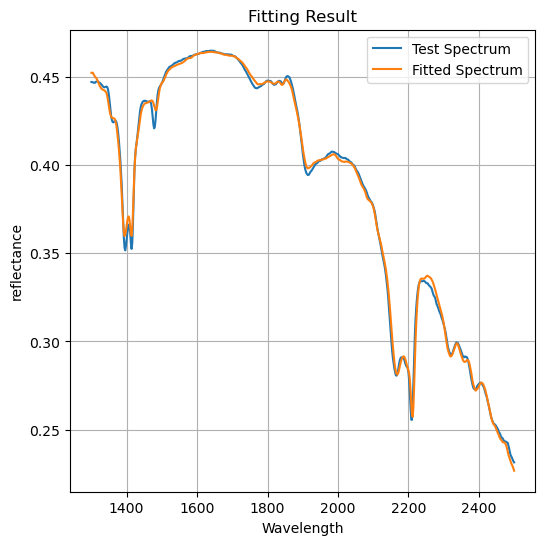

KAOLINOR: 22.66%
NH4ILLIT: 20.50%
LABRADOR: 13.29%
HALLOYSI: 10.25%
PYROPHYL: 8.34%
ALUNITE2: 8.32%
TOURMALI: 6.52%
DICKITE: 3.13%
TITANITE: 1.86%
TSCHMERI: 1.67%
BERYL: 0.87%
GIBBSITE: 0.59%
ANTLERIT: 0.44%
TALC: 0.42%
JAROSIT1: 0.40%
HYDAPOPH: 0.39%
EPIDOTE1: 0.33%


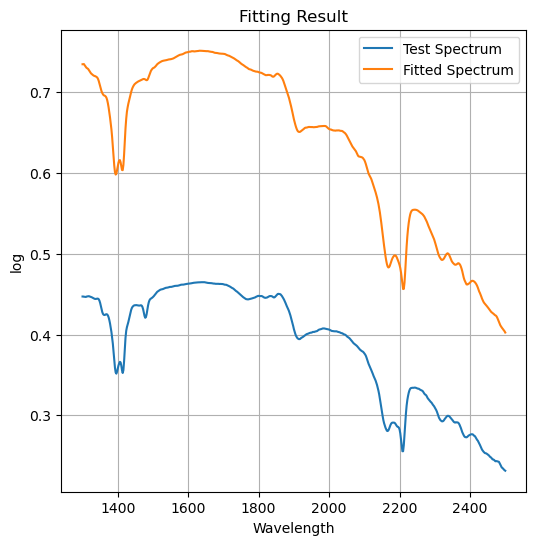

KAOLINOR: 40.68%
HALLOYSI: 37.23%
NH4ILLIT: 5.68%
ALUNITE2: 5.28%
ANTIGORI: 4.08%
BRUCITE: 2.82%
ANORTHIT: 1.78%
ANDESINE: 1.58%
PYROPHYL: 0.86%


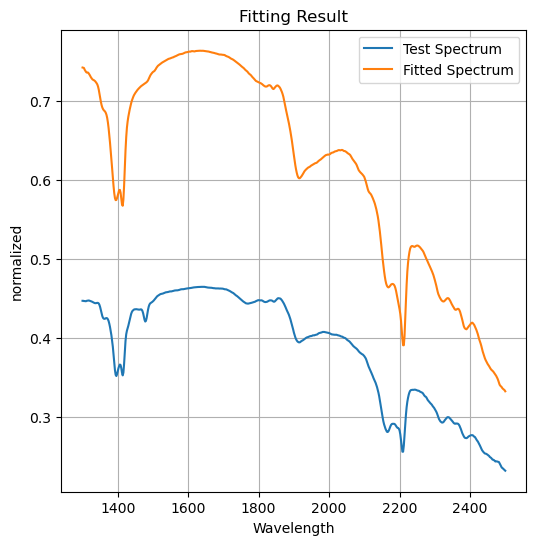

In [54]:
def unmix_nnls(spectrum_lib, test_spectrum, attr='normalized'):
    A, y = get_matrix(spectrum_lib, test_spectrum, attr)
    x, rnorm = nnls(A, y)
    components = []
    for i, mine_name in enumerate(spectrum_lib.keys()):
        if x[i] > 0.0:
            components.append((mine_name, x[i]))
    components.sort(key=lambda x: x[1], reverse=True)
    total = sum([abundance for mine_name, abundance in components])
    components = [(mine_name, abundance/total) for mine_name, abundance in components]
    for mine_name, abundance in components:
        print(f'{mine_name}: {abundance*100:.2f}%')
    # 计算拟合的反射率
    normalized_arrays = [df['reflectance'].values for df in spectrum_lib.values()]
    merged_array = np.vstack(normalized_arrays)
    transposed_array = merged_array.T
    fitted_reflectance = np.dot(transposed_array, x)
    # 绘制拟合结果，即测试光谱数据和拟合结果的对比
    plt.figure(figsize=(6, 6))
    plt.plot(test_spectrum['wavelength'], test_spectrum['reflectance'], label='Test Spectrum')
    plt.plot(test_spectrum['wavelength'], fitted_reflectance, label='Fitted Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel(attr)
    plt.title('Fitting Result')
    plt.legend()
    plt.grid(True)
    plt.show()

unmix_nnls(spectrum_lib, multi_lib['al10ka90'],'reflectance')
unmix_nnls(spectrum_lib, multi_lib['al10ka90'],'log')
unmix_nnls(spectrum_lib, multi_lib['al10ka90'],'normalized')

### PCA+NNLS

In [55]:
from sklearn.decomposition import PCA

# 假设我们有三个端元光谱
endmembers = np.array([
    [1, 2, 3, 4, 5],
    [2, 3, 2, 5, 4],
    [1, 4, 5, 4, 1]
])

# 假设我们有一个混合光谱
mixed_spectrum = np.array([2.5, 3.5, 3.5, 4.5, 3.5]).reshape(-1, 1)

A,y = get_matrix(spectrum_lib, multi_lib['al10ka90'])
endmembers = np.array(A)
mixed_spectrum = np.array(y).reshape(-1, 1)

# 使用PCA进行特征提取
pca = PCA(n_components=0.95)
pca_endmembers = pca.fit_transform(A.T)

# 将混合光谱映射到PCA空间
pca_mixed_spectrum = pca.transform(mixed_spectrum.T)

# 使用NNLS进行光谱解混
weights, _ = nnls(pca_endmembers.T, pca_mixed_spectrum[0])

print(len(weights), "端元权重：", weights)

63 端元权重： [0.         0.10353079 0.40888051 0.017727   0.         0.06494259
 0.06735722 0.         0.         0.09224533 0.         0.15335302
 0.         0.         0.         0.         0.         0.0669641
 0.         0.         0.         0.         0.         0.22455173
 0.         0.06653686 0.91053421 0.00095461 0.         0.
 0.         0.         0.         0.         0.         0.11167944
 0.         0.         0.         0.06835    0.06522645 0.07162975
 0.15123827 0.17913123 0.         0.         0.         0.
 0.         0.         0.         0.         0.06153201 0.04817047
 0.19129378 0.         0.         0.013089   0.04740012 0.
 0.         0.00795115 0.        ]


 假设你有一组已知的光谱端元数据X，以及未知光谱的数据y

 X是一个二维数组，每一列代表一个端元的反射率数据，每个端元都有601个波长的反射率数据

 y是一个一维数组，代表未知光谱的反射率数据

 假设X是62列，每一列是一个端元的数据，y是未知光谱的数据
 
 这里仅为示例，假设X和y都是随机生成的数据

In [56]:
# from sklearn.linear_model import LassoCV
# from sklearn.preprocessing import StandardScaler

# X = np.random.rand(601, 62)  # 62个端元，每个端元有601个波长的数据
# y = np.random.rand(601)  # 未知光谱数据，601个波长的数据

# # 特征标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 创建LASSO回归模型，并进行交叉验证选择最佳的alpha值
# lasso_cv = LassoCV(cv=5)
# lasso_cv.fit(X_scaled, y)

# # 打印最佳的alpha值
# print("最佳的alpha值：", lasso_cv.alpha_)

# # 打印选择的端元的权重（系数）
# selected_features_indices = np.where(lasso_cv.coef_ != 0)[0]
# selected_features_weights = lasso_cv.coef_[selected_features_indices]
# print("选择的端元权重：", selected_features_weights)

# # 利用选择的端元对未知光谱进行预测
# selected_features = X_scaled[:, selected_features_indices]
# predicted_spectrum = np.dot(selected_features, selected_features_weights)

# # 打印预测的未知光谱数据
# print("预测的未知光谱数据：", predicted_spectrum)


### LASSO

In [60]:
from sklearn.linear_model import Lasso
import numpy as np
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score

# X是一个62x601的二维数组，每一行代表一个端元的反射率数据，共有62个端元，每个端元有601个波长的反射率数据
# y是一个包含601个波长的一维数组，代表未知光谱的反射率数据

X_known,y_unknown=get_matrix(spectrum_lib, multi_lib['chris6a'],'log')
X_known = np.array(X_known).T
# 创建LASSO回归模型，并拟合已知光谱端元数据
lasso = Lasso(alpha=0.0005, positive=True)  # alpha是L1正则化参数，调整正则化的强度
lasso.fit(X_known.T, y_unknown)  # 拟合模型，需要对X_known进行转置

# 获取端元系数（即端元的权重）
endmember_coefficients = lasso.coef_

mines=spectrum_lib.keys()
max_mines=2
# 只保留端元系数大于0的端元，并从大到小排序，取前max_mines个，计算端元的相对丰度
endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in zip(mines, endmember_coefficients) if coef > 0]
endmember_coefficients_less.sort(key=lambda x: x[1], reverse=True)
endmember_coefficients_less = endmember_coefficients_less[:max_mines]
total = sum([coef for mine_name, coef in endmember_coefficients_less])
endmember_coefficients_less = [(mine_name, coef/total) for mine_name, coef in endmember_coefficients_less]
print("端元系数：", endmember_coefficients_less)

# 计算解混后的未知光谱
unmixed_spectrum = np.dot(endmember_coefficients, X_known)

# 打印解混后的未知光谱
# print("解混后的未知光谱：", unmixed_spectrum)

# 评价指标
mse = mean_squared_error(y_unknown, unmixed_spectrum)
explained_var = explained_variance_score(y_unknown, unmixed_spectrum)
r2 = r2_score(y_unknown, unmixed_spectrum)
cross_val_scores = cross_val_score(lasso, X_known.T, y_unknown, cv=5)
# 打印评价指标
print("均方误差（MSE）：", mse)
print("解释方差：", explained_var)
print("决定系数（R²）：", r2)
print("交叉验证得分：", cross_val_scores)
print("平均交叉验证得分：", np.mean(cross_val_scores))

def unmix_lasso(spectrum_lib,unknown_spectrum,attr='log',alpha=0.003,max_mines=2,min_account=0.1):
    # 获取端元数据和未知光谱数据
    X_known,y_unknown=get_matrix(spectrum_lib, unknown_spectrum,'normalized')
    X_known = np.array(X_known).T
    # 创建LASSO回归模型，并拟合已知光谱端元数据
    lasso = Lasso(alpha=alpha, positive=True)
    lasso.fit(X_known.T, y_unknown)
    # 获取端元系数（即端元的权重）
    endmember_coefficients = lasso.coef_
    # 处理端元系数
    mines=spectrum_lib.keys()
    # 提取权重大于0的端元
    endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in zip(mines, endmember_coefficients) if coef > 0]
    # 对权重进行排序
    endmember_coefficients_less.sort(key=lambda x: x[1], reverse=True)
    # 只保留前max_mines个端元
    endmember_coefficients_less = endmember_coefficients_less[:max_mines]
    # 归一化权重，使其成为比例 for reporting
    total = sum([coef for mine_name, coef in endmember_coefficients_less])
    endmember_coefficients_less = [(mine_name, coef/total) for mine_name, coef in endmember_coefficients_less]
    # 剔除权重小于min_account的端元
    endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in endmember_coefficients_less if coef > min_account]
    # 归一化权重，使其成为比例 for reporting
    total = sum([coef for mine_name, coef in endmember_coefficients_less])
    endmember_coefficients_less = [(mine_name, coef/total) for mine_name, coef in endmember_coefficients_less]
    # 创建一个只包含已选择端元的矩阵
    selected_endmember_matrix = np.column_stack([spectrum_lib[mine_name][attr].values for mine_name, coef in endmember_coefficients_less])
    # 使用这个矩阵和端元系数进行点积运算，得到拟合的混合光谱
    fitted_mixture_spectrum = np.dot(selected_endmember_matrix, [coef for mine_name, coef in endmember_coefficients_less])
    # 计算各种评价指标
    mse = mean_squared_error(y_unknown, fitted_mixture_spectrum)
    explained_var = explained_variance_score(y_unknown, fitted_mixture_spectrum)
    r2 = r2_score(y_unknown, fitted_mixture_spectrum)
    cross_val_scores = cross_val_score(lasso, X_known.T, y_unknown, cv=10)
    cross_val_scores_mean=np.mean(cross_val_scores)
    # 计算rss
    rss = np.sum((y_unknown - fitted_mixture_spectrum) ** 2)
    
    return endmember_coefficients_less,mse,explained_var,r2,cross_val_scores_mean,rss

# 对multi_lib中的所有光谱进行解混,并以表格形式输出评价指标便于对比
import pandas as pd
from IPython.display import display

results = []
for mine_name, df in multi_lib.items():
    endmember_coefficients,mse,explained_var,r2,cross_val_scores_mean,rss = unmix_lasso(spectrum_lib, df)
    results.append([mine_name, endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean,rss])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Endmember Coefficients', 'MSE', 'Explained Variance', 'R²', 'Cross-Validation Score', 'RSS'])
display(df_results)


端元系数： [('KAOLINOR', 0.7617978577150241), ('AZURITE', 0.238202142284976)]
均方误差（MSE）： 0.0510611924993863
解释方差： 0.9839988771935076
决定系数（R²）： -3.215199381446805
交叉验证得分： [ 0.63820766 -0.21812255  0.88379129  0.45229995  0.75665009]
平均交叉验证得分： 0.5025652901724282


,Mine Name,Endmember Coefficients,MSE,Explained Variance,R²,Cross-Validation Score,RSS
0,al10ka90,"[(HALLOYSI, 0.5142074471909996), (KAOLINOR, 0....",0.837854,-0.988750,-90.466768,0.392354,503.550400
1,al20ka80,"[(KAOLINOR, 0.5276130118150274), (HALLOYSI, 0....",0.846360,-1.005558,-91.427785,0.488930,508.662155
2,al40ka60,"[(HALLOYSI, 0.6386441985413623), (ALUNITE2, 0....",0.919936,-1.049132,-98.082682,0.570772,552.881561
3,alkaxx,"[(ALUNITE2, 0.6142189288708456), (HALLOYSI, 0....",1.016290,-1.036593,-95.079401,0.584046,610.790285
4,alpyro2,"[(PYROPHYL, 1.0)]",0.836323,-0.860259,-80.787174,0.345406,502.630364
5,chris2a,"[(PYROPHYL, 0.7148979917072376), (ALUNITE2, 0....",1.000363,-1.038121,-96.512949,0.203592,601.217968
6,chris3b,"[(ALUNITE2, 0.6691751681647623), (KAOLINOR, 0....",1.044806,-1.384096,-110.549312,0.340451,627.928176
7,chris4b,"[(NONTRON2, 0.5198197356842544), (SCHEELIT, 0....",0.868092,-0.111210,-78.130270,0.280650,521.723512
8,chris5a,"[(SCHEELIT, 0.6312971727895126), (ANDESINE, 0....",0.701317,0.009934,-46.034509,0.478265,421.491615
9,chris6a,"[(HALLOYSI, 0.6703897006157991), (ANDESINE, 0....",0.807392,-0.368205,-84.259018,0.406382,485.242607


#### L1正则化强度系数选择

al10ka90
突变点的alpha值: [0.00011 0.00012 0.00017 0.00019 0.0002  0.00022 0.00023 0.00025 0.00026
 0.00053 0.00058 0.00073 0.00075 0.00081 0.00084 0.00099 0.00116 0.00143
 0.00145 0.00177 0.00275 0.00492]
突变点的size差值: [-1 -1 -1 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


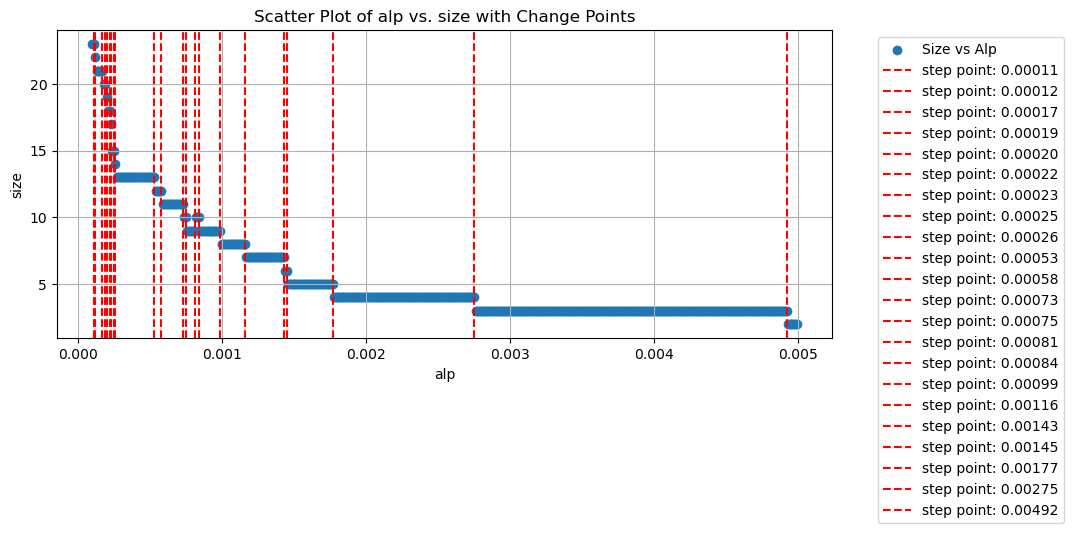

al20ka80
突变点的alpha值: [0.0001  0.00011 0.00014 0.00015 0.00019 0.0002  0.00022 0.00031 0.00034
 0.00056 0.00062 0.00074 0.00077 0.00084 0.00091 0.00094 0.00114 0.00133
 0.00166 0.0048 ]
突变点的size差值: [-1 -1 -1 -1 -2 -1 -1 -1 -1 -2 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]


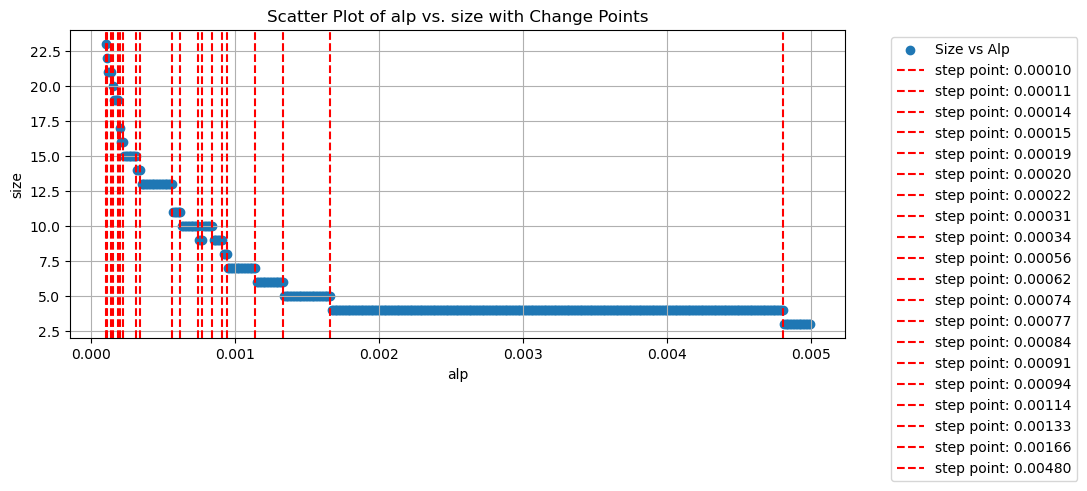

al40ka60
突变点的alpha值: [0.00011 0.00012 0.00014 0.00015 0.00018 0.00019 0.0002  0.00031 0.00034
 0.00056 0.0006  0.00061 0.00074 0.00096 0.00107 0.00108 0.00135 0.00158
 0.00179 0.00407 0.00417]
突变点的size差值: [-1 -2 -1 -2 -1 -1 -1 -2 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


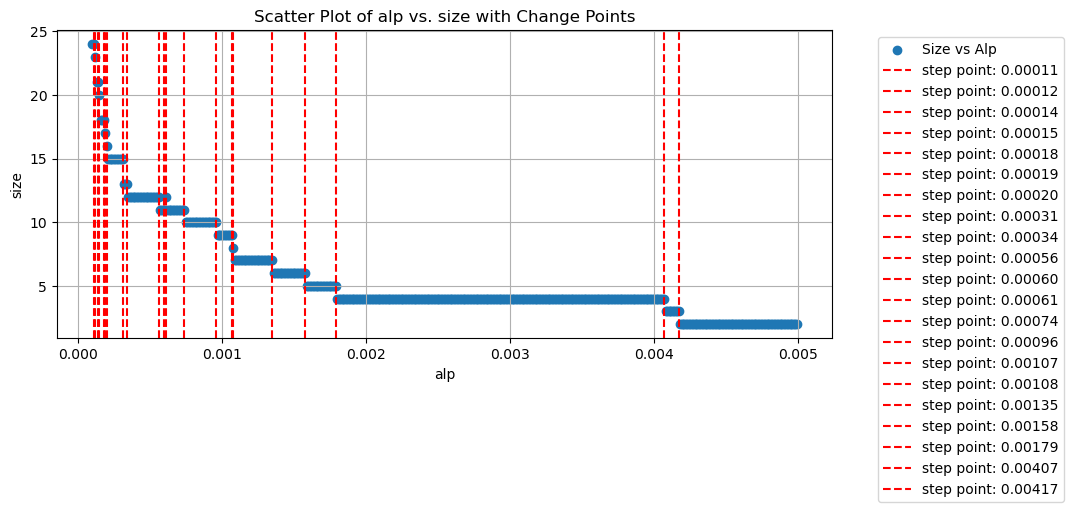

alkaxx
突变点的alpha值: [0.00013 0.00015 0.00017 0.00018 0.0002  0.00023 0.00027 0.00033 0.00038
 0.00051 0.00069 0.00073 0.00087 0.00088 0.00095 0.00099 0.00133 0.00168
 0.0024 ]
突变点的size差值: [-1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -2 -1 -1 -1 -1]


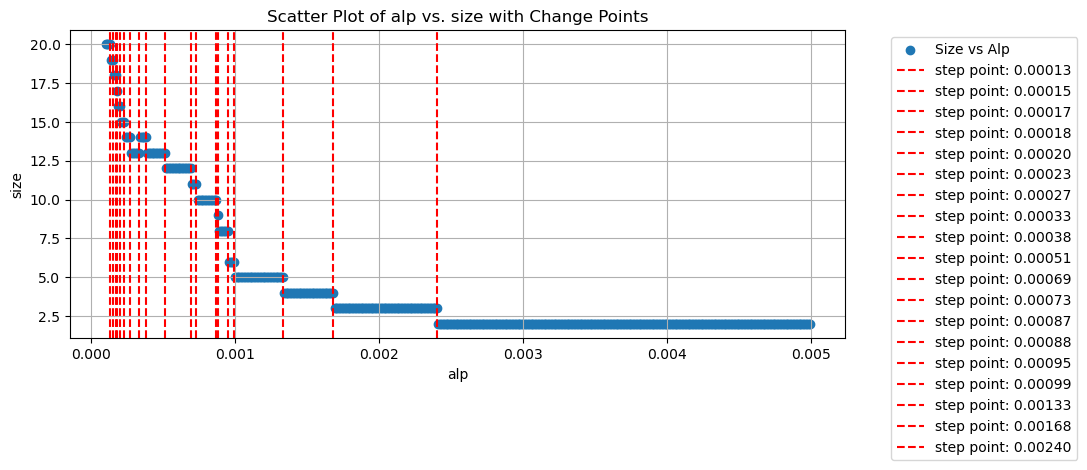

alpyro2
突变点的alpha值: [0.0001  0.00012 0.00013 0.00014 0.00016 0.00017 0.00018 0.0002  0.00022
 0.00023 0.00024 0.00031 0.00036 0.00037 0.00044 0.00053 0.00059 0.00069
 0.00198 0.00229 0.0038 ]
突变点的size差值: [-2 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -1 -1 -1 -1]


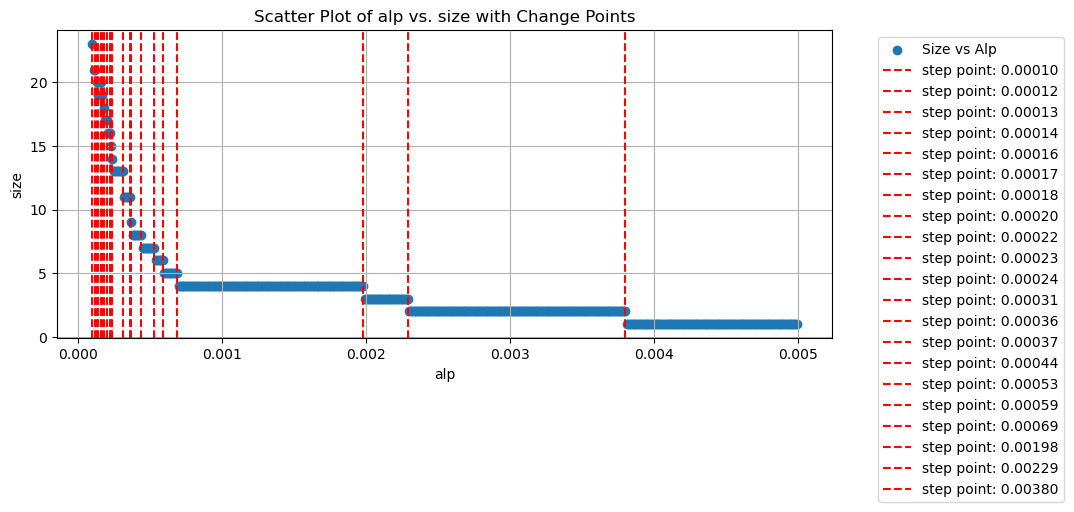

chris2a
突变点的alpha值: [0.00011 0.00013 0.00018 0.00021 0.00023 0.00037 0.00049 0.00056 0.00087
 0.00093 0.00094 0.00104 0.00109 0.00112 0.00134 0.00165 0.00184 0.00195
 0.00202 0.00205 0.00331]
突变点的size差值: [-2 -1 -1 -1 -2 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


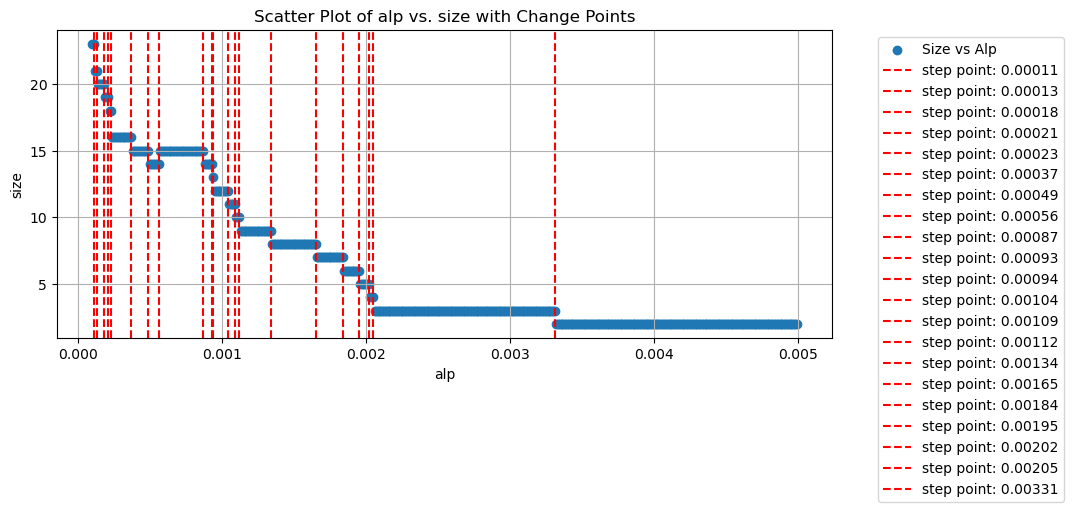

chris3b
突变点的alpha值: [0.00011 0.00014 0.00017 0.00026 0.00033 0.00039 0.00041 0.00045 0.00046
 0.00048 0.00052 0.00063 0.00079 0.00083 0.00095 0.00113 0.00167 0.00176
 0.00188 0.00224 0.00436 0.00498]
突变点的size差值: [-3 -1 -1  1 -1 -1 -1  1 -1 -2 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]


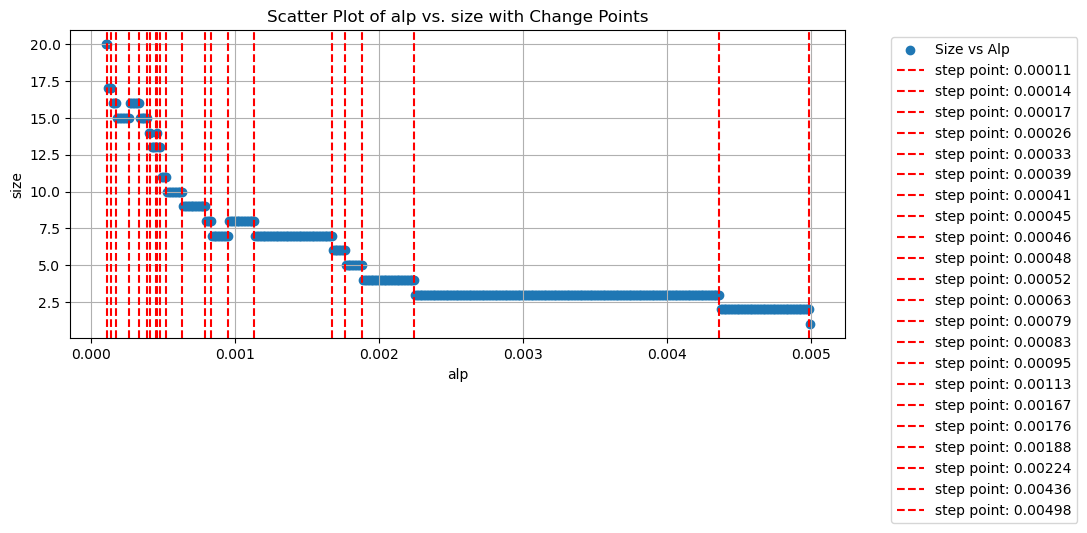

chris4b
突变点的alpha值: [0.00011 0.00013 0.00016 0.00022 0.00031 0.00033 0.00034 0.00037 0.00071
 0.00086 0.00105 0.00115 0.00142 0.00211 0.00385 0.00392]
突变点的size差值: [-1 -1 -2 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1]


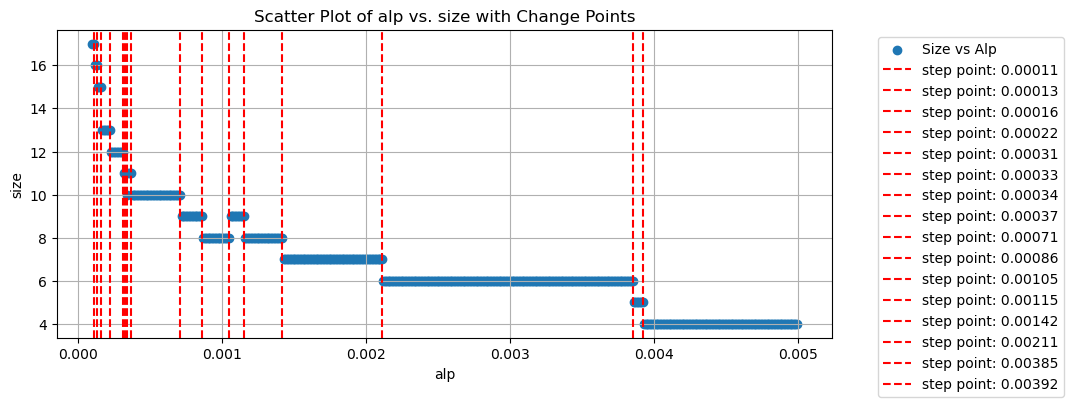

chris5a
突变点的alpha值: [0.00013 0.00022 0.00023 0.00026 0.00029 0.0003  0.00031 0.00036 0.00044
 0.00054 0.00072 0.00078 0.0008  0.00083 0.00087 0.001   0.00106 0.00151
 0.00344 0.00428]
突变点的size差值: [-2  1 -1  1 -1 -1 -1 -2  1 -1 -1 -1 -1 -2 -1 -1 -1 -1 -1 -1]


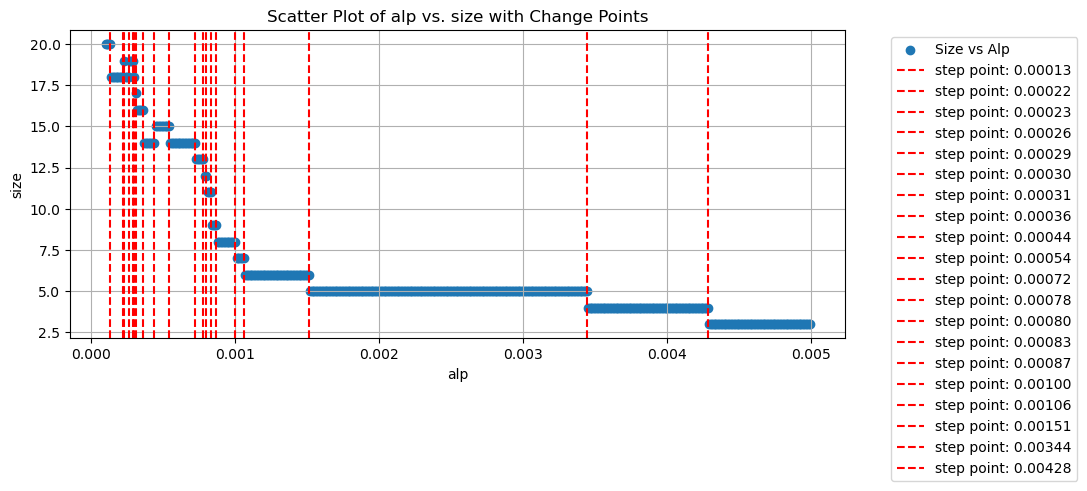

chris6a
突变点的alpha值: [0.00011 0.00015 0.00016 0.0002  0.00021 0.00038 0.00046 0.0005  0.00059
 0.0006  0.00068 0.00114 0.00116]
突变点的size差值: [-3 -1 -1 -1 -1 -1 -1 -1 -2 -1 -1 -1 -1]


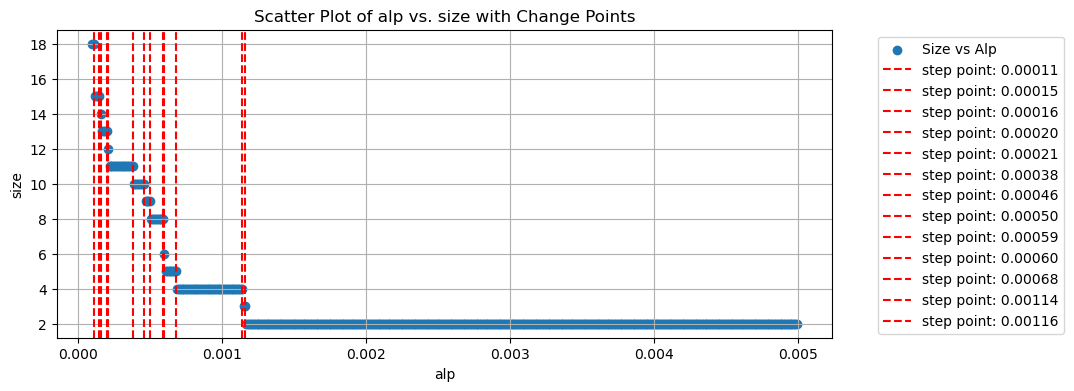

chris6c
突变点的alpha值: [0.00014 0.00015 0.00019 0.00023 0.00025 0.00028 0.0003  0.00036 0.00041
 0.00051 0.00076 0.00085 0.00086 0.00096 0.00097 0.00104 0.00123 0.00136
 0.0019  0.0029  0.0048 ]
突变点的size差值: [-1 -2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


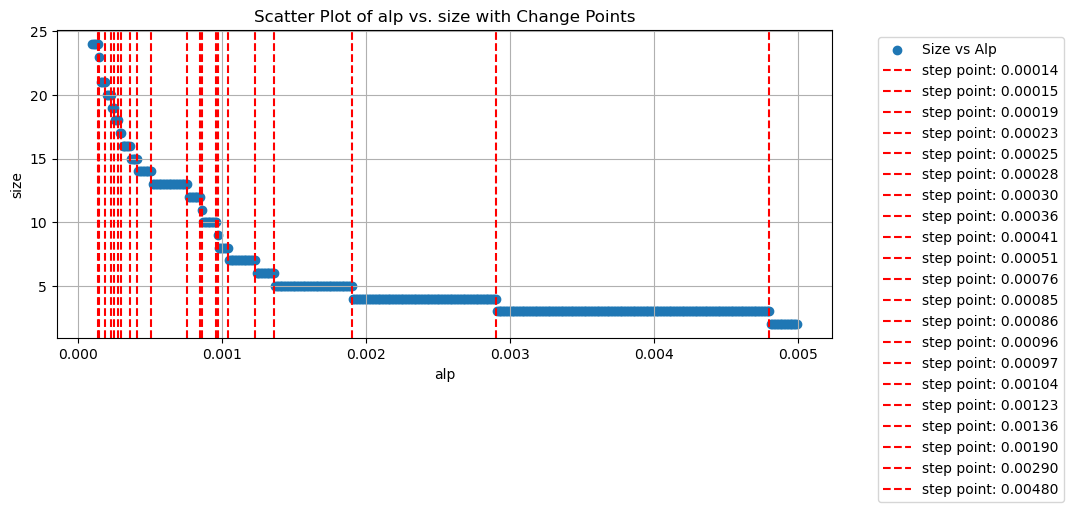

chris7a
突变点的alpha值: [0.00011 0.00015 0.00017 0.00018 0.0002  0.0003  0.00037 0.00048 0.00067
 0.00117 0.00159 0.00162 0.00163 0.00178 0.00208 0.00316 0.00337]
突变点的size差值: [-1 -2 -1 -1 -1 -1 -2  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


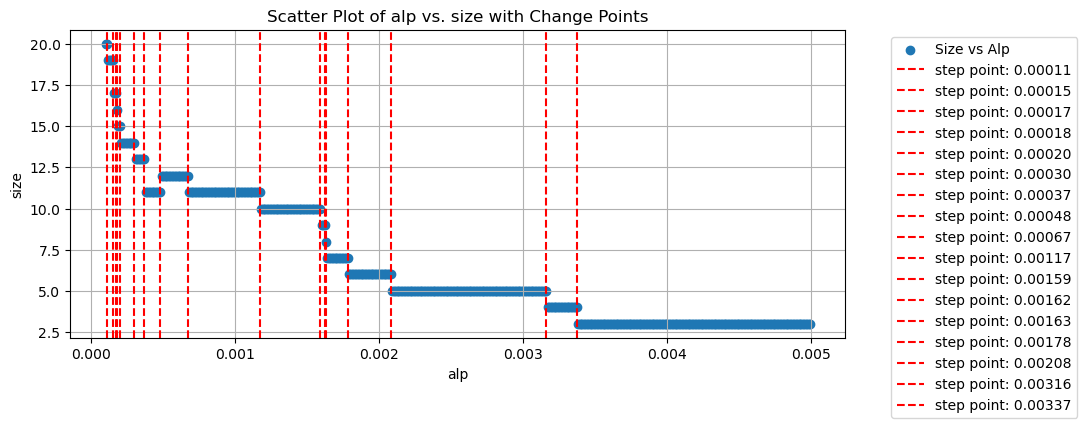

chris7b
突变点的alpha值: [0.00011 0.00014 0.00015 0.00017 0.00018 0.00021 0.00032 0.00034 0.00036
 0.0004  0.00042 0.00045 0.00064 0.00073 0.00095 0.00171 0.00186 0.00197
 0.00231 0.00254 0.0038  0.00466]
突变点的size差值: [-2 -1  1 -1 -1 -2 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


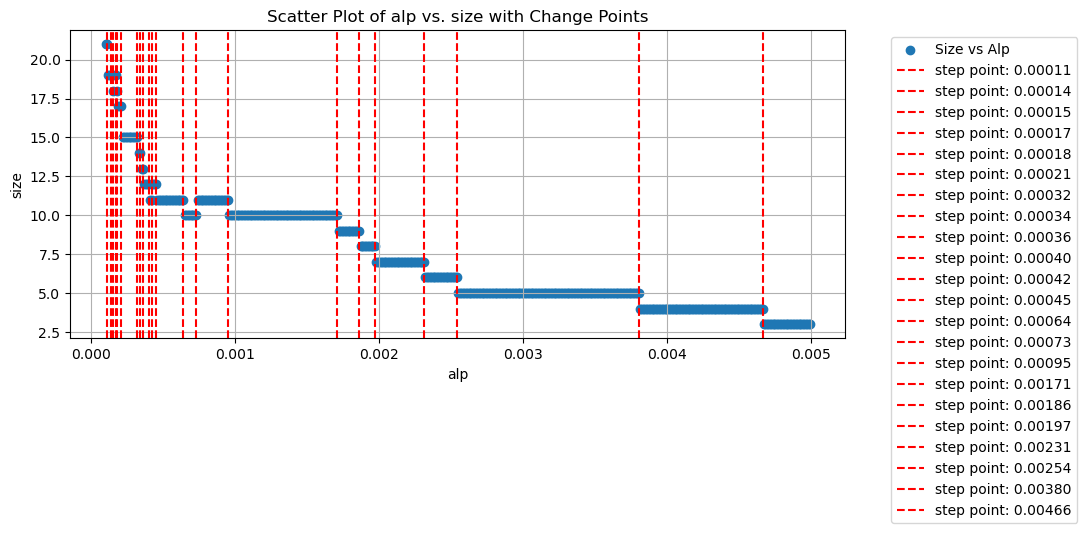

kaolIll
突变点的alpha值: [0.0001  0.00011 0.00012 0.00018 0.0002  0.00024 0.00027 0.00029 0.00033
 0.00039 0.00042 0.00043 0.00048 0.0006  0.00079 0.00122 0.0014  0.00141
 0.00146 0.00157 0.00202 0.00336]
突变点的size差值: [-2  1 -1 -1 -1 -2 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


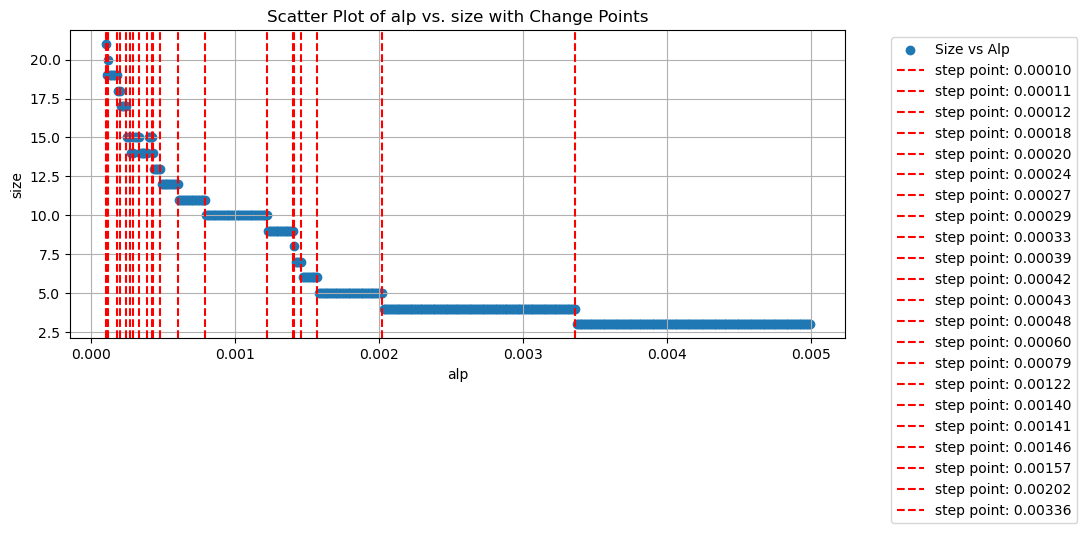

pyroill2
突变点的alpha值: [0.0001  0.00011 0.00012 0.00016 0.00022 0.00023 0.00026 0.00027 0.00029
 0.00032 0.00034 0.00038 0.00041 0.00048 0.00054 0.00056 0.00074 0.00075
 0.00079 0.00091 0.00093 0.00126 0.00158]
突变点的size差值: [-1 -1 -2 -1 -2 -1 -1 -1  1  1  1  1 -2 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]


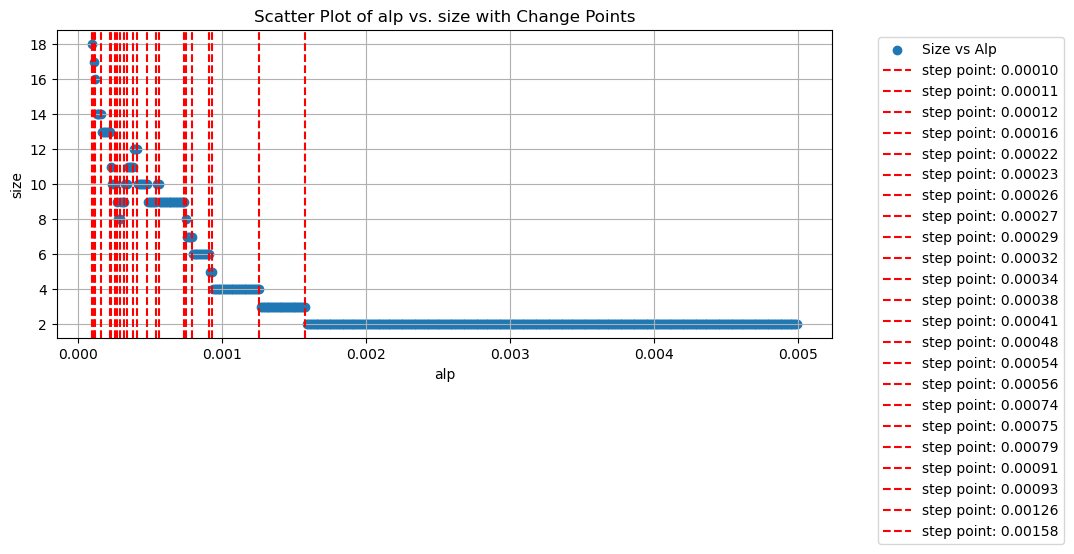

In [58]:
def unmix_lasso_test(spectrum_lib,unknown_spectrum,attr='log',alpha=0.0005):
    # 获取端元数据和未知光谱数据
    X_known,y_unknown=get_matrix(spectrum_lib, unknown_spectrum,'normalized')
    X_known = np.array(X_known).T
    # 创建LASSO回归模型，并拟合已知光谱端元数据
    lasso = Lasso(alpha=alpha, positive=True)
    lasso.fit(X_known.T, y_unknown)
    # 获取端元系数（即端元的权重）
    endmember_coefficients = lasso.coef_
    # 处理端元系数
    mines=spectrum_lib.keys()
    # 提取权重大于0的端元
    endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in zip(mines, endmember_coefficients) if coef > 0]
    # 对权重进行排序
    endmember_coefficients_less.sort(key=lambda x: x[1], reverse=True)
    size = len(endmember_coefficients_less)
    return size

# 创建alp值的数组
alp_values = np.arange(0.0001, 0.005, 0.00001)
# 对每个光谱作alpha突变图
for mn,df in multi_lib.items():
    print(mn)
    # 记录每个alp值对应的size
    sizes = [unmix_lasso_test(spectrum_lib,df,alpha=alp) for alp in alp_values]

    # 计算相邻size值的差值
    size_diffs = np.diff(sizes)
    # 设置突变点的阈值
    threshold = 0

    # 找到差值超过阈值的点
    change_points = np.where(size_diffs != threshold)[0]

    # 输出突变点的alp值和对应的size差值
    change_points_alp = alp_values[change_points]
    change_points_diff = size_diffs[change_points]

    print('突变点的alpha值:', change_points_alp)
    print('突变点的size差值:', change_points_diff)

    # 绘制散点图并标注突变点
    plt.figure(figsize=(10, 4))
    plt.scatter(alp_values, sizes, label='Size vs Alp')
    for cp_alp in change_points_alp:
        plt.axvline(x=cp_alp, color='r', linestyle='--', label=f'step point: {cp_alp:.5f}')
    plt.title('Scatter Plot of alp vs. size with Change Points')
    plt.xlabel('alp')
    plt.ylabel('size')

    # 调整图例位置
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()
    

#### 根据上述结果，选择alpha

In [20]:
results = []
for mine_name, df in multi_lib.items():
    endmember_coefficients,mse,explained_var,r2,cross_val_scores_mean,rss = unmix_lasso(spectrum_lib, df,alpha=0.002)
    results.append([mine_name, endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean,rss])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Endmember Coefficients', 'MSE', 'Explained Variance', 'R²', 'Cross-Validation Score', 'RSS'])
display(df_results)

,Mine Name,Endmember Coefficients,MSE,Explained Variance,R²,Cross-Validation Score,RSS
0,al10ka90,"[(HALLOYSI, 1.0)]",0.723771,-1.645232,-125.382887,0.098868,434.986488
1,al20ka80,"[(HALLOYSI, 0.8978316622727048), (KAOLINOR, 0....",0.718163,-1.691414,-124.926679,0.167196,431.616076
2,al40ka60,"[(HALLOYSI, 1.0)]",0.706255,-1.677645,-124.528567,0.167061,424.459488
3,alkaxx,"[(HALLOYSI, 0.7408245259978888), (ALUNITE2, 0....",0.710316,-1.884472,-126.111807,0.041040,426.899633
4,alpyro2,"[(PYROPHYL, 1.0)]",0.725468,-2.403941,-144.551556,0.068225,436.006520
5,chris2a,"[(PYROPHYL, 1.0)]",0.740308,-3.160402,-188.444435,0.032770,444.925352
6,chris3b,"[(HALLOYSI, 0.8495098216552472), (KAOLINOR, 0....",0.704023,-1.678435,-118.105468,0.073192,423.117797
7,chris4b,"[(NONTRON2, 0.5904875589424743), (MONTMORI, 0....",0.943708,-0.895466,-103.470420,0.261870,567.168483
8,chris5a,"[(AZURITE, 0.6826891650675955), (WITHERIT, 0.3...",1.151316,-0.545315,-74.812894,0.120719,691.940948
9,chris6a,"[(HALLOYSI, 1.0)]",0.699240,-1.742051,-129.849330,0.309255,420.243062


### 岭回归

In [21]:
from sklearn.linear_model import Ridge
def unmix_ridge(spectrum_lib, unknown_spectrum, attr='log', alpha=0.2, max_mines=2,min_account=0.1):
    # 获取端元数据和未知光谱数据
    X_known, y_unknown = get_matrix(spectrum_lib, unknown_spectrum, attr)
    X_known = np.array(X_known).T
    # 创建Ridge回归模型，并拟合已知光谱端元数据
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_known.T, y_unknown)
    # 获取端元系数（即端元的权重）
    endmember_coefficients = ridge.coef_
    # 处理端元系数
    mines = spectrum_lib.keys()
    # 提取权重大于0的端元
    endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in zip(mines, endmember_coefficients) if coef > 0]
    # 对权重进行排序
    endmember_coefficients_less.sort(key=lambda x: x[1], reverse=True)
    # 只保留前max_mines个端元
    endmember_coefficients_less = endmember_coefficients_less[:max_mines]
    # 归一化权重，使其成为比例 for reporting
    total = sum([coef for mine_name, coef in endmember_coefficients_less])
    endmember_coefficients_less = [(mine_name, coef/total) for mine_name, coef in endmember_coefficients_less]
    # 剔除权重小于min_account的端元
    endmember_coefficients_less = [(mine_name, coef) for mine_name, coef in endmember_coefficients_less if coef > min_account]
    # 归一化权重，使其成为比例 for reporting
    total = sum([coef for mine_name, coef in endmember_coefficients_less])
    endmember_coefficients_less = [(mine_name, coef/total) for mine_name, coef in endmember_coefficients_less]
    # 创建一个只包含已选择端元的矩阵
    selected_endmember_matrix = np.column_stack([spectrum_lib[mine_name][attr].values for mine_name, coef in endmember_coefficients_less])
    # 使用这个矩阵和端元系数进行点积运算，得到拟合的混合光谱
    fitted_mixture_spectrum = np.dot(selected_endmember_matrix, [coef for mine_name, coef in endmember_coefficients_less])
    # 计算各种评价指标
    mse = mean_squared_error(y_unknown, fitted_mixture_spectrum)
    explained_var = explained_variance_score(y_unknown, fitted_mixture_spectrum)
    r2 = r2_score(y_unknown, fitted_mixture_spectrum)
    cross_val_scores = cross_val_score(ridge, X_known.T, y_unknown, cv=10)
    cross_val_scores_mean = np.mean(cross_val_scores)
    return endmember_coefficients_less, mse, explained_var, r2, cross_val_scores_mean

results = []
for mine_name, df in multi_lib.items():
    endmember_coefficients,mse,explained_var,r2,cross_val_scores_mean = unmix_ridge(spectrum_lib, df)
    results.append([mine_name, endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Endmember Coefficients', 'MSE', 'Explained Variance', 'R²', 'Cross-Validation Score'])
display(df_results)
# 结果输出于out文件夹
df_results.to_csv('../out/results.csv',index=False)


,Mine Name,Endmember Coefficients,MSE,Explained Variance,R²,Cross-Validation Score
0,al10ka90,"[(KAOLINOR, 0.5399908706155353), (ALUNITE2, 0....",0.019389,0.848833,-1.514092,-0.133081
1,al20ka80,"[(ALUNITE2, 0.5950170112242203), (KAOLINOR, 0....",0.005565,0.887027,0.353614,0.161598
2,al40ka60,"[(ALUNITE2, 0.6324373808266831), (KAOLINOR, 0....",0.008008,0.901218,0.110327,-0.145818
3,alkaxx,"[(ALUNITE2, 0.7607499011661032), (KAOLINOR, 0....",0.020168,0.982695,-0.478362,-3.951970
4,alpyro2,"[(PYROPHYL, 0.6233994968102834), (ALUNITE2, 0....",0.384452,0.823173,-41.461650,0.353805
5,chris2a,"[(ALUNITE2, 0.5709351848419373), (WATER2, 0.42...",0.166741,0.764991,-5.969077,-0.128174
6,chris3b,"[(ALUNITE2, 0.5850624254264875), (TRONA, 0.414...",0.397020,-0.179725,-89.511476,-0.046875
7,chris4b,"[(MONTMORI, 0.5497378092351115), (MUSCOVIT, 0....",0.278454,0.855850,-13.159067,0.495891
8,chris5a,"[(MUSCOVIT, 0.5711672013142456), (MONTMORI, 0....",0.477104,0.813508,-124.578779,0.045289
9,chris6a,"[(HALLOYSI, 0.5092316804788326), (KAOLINOR, 0....",0.098016,0.956450,-7.091393,-0.955980


OSError: Cannot save file into a non-existent directory: '..\out'

### PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

X_known,y_unknown=get_matrix(spectrum_lib, multi_lib['chris6a'],'log')
X_known = np.array(X_known)

# 创建PLS模型
pls = PLSRegression(n_components=61)

# 拟合PLS模型
pls.fit(X_known, y_unknown)

# 获取端元系数
endmember_coefficients = pls.x_weights_

# 将负数系数转为0
endmember_coefficients[endmember_coefficients < 0] = 0

# 重新归一化系数
endmember_coefficients /= np.sum(endmember_coefficients)

# 计算解混后的未知光谱
unmixed_spectrum = pls.predict(X_known)

# 计算评价指标
mse = mean_squared_error(y_unknown, unmixed_spectrum)
explained_var = explained_variance_score(y_unknown, unmixed_spectrum)
r2 = r2_score(y_unknown, unmixed_spectrum)
cross_val_scores = cross_val_score(pls, X_known, y_unknown, cv=5)
cross_val_scores_mean = np.mean(cross_val_scores)

# 返回结果
print("端元系数：", endmember_coefficients)
print("均方误差（MSE）：", mse)
print("解释方差：", explained_var)
print("决定系数（R²）：", r2)
print("平均交叉验证得分：", cross_val_scores_mean)

def unmix_pls(spectrum_lib, unknown_spectrum, attr='log', n_components=2):
    X_known, y_unknown = get_matrix(spectrum_lib, unknown_spectrum, attr)
    X_known = np.array(X_known).T

    # 创建PLS模型
    pls = PLSRegression(n_components=n_components)

    # 拟合PLS模型
    pls.fit(X_known, y_unknown)

    # 获取端元系数
    endmember_coefficients = pls.x_weights_

    # 将负数系数转为0
    endmember_coefficients[endmember_coefficients < 0] = 0

    # 重新归一化系数
    endmember_coefficients /= np.sum(endmember_coefficients)

    # 计算解混后的未知光谱
    unmixed_spectrum = pls.predict(X_known)

    # 计算评价指标
    mse = mean_squared_error(y_unknown, unmixed_spectrum)
    explained_var = explained_variance_score(y_unknown, unmixed_spectrum)
    r2 = r2_score(y_unknown, unmixed_spectrum)
    cross_val_scores = cross_val_score(pls, X_known, y_unknown, cv=5)
    cross_val_scores_mean = np.mean(cross_val_scores)

    # 返回结果
    return endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean



# 对multi_lib中的所有光谱进行解混,并以表格形式输出评价指标便于对比
# import pandas as pd
# from IPython.display import display

# results = []
# for mine_name, df in multi_lib.items():
#     endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean = unmix_pls(spectrum_lib, df)
#     results.append([mine_name, endmember_coefficients, mse, explained_var, r2, cross_val_scores_mean])

# df_results = pd.DataFrame(results, columns=['Mine Name', 'Endmember Coefficients', 'MSE', 'Explained Variance', 'R²', 'Cross-Validation Score'])
# display(df_results)

端元系数： [[6.00306587e-04 1.40718354e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.36533506e-04 8.15690934e-04 9.67495426e-04 ... 5.77817769e-05
  4.34373047e-06 0.00000000e+00]
 [4.55721247e-04 1.48412150e-03 0.00000000e+00 ... 0.00000000e+00
  1.92721791e-03 0.00000000e+00]
 ...
 [3.38872191e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.76483946e-04 0.00000000e+00]
 [6.47555121e-04 0.00000000e+00 0.00000000e+00 ... 8.68237946e-04
  0.00000000e+00 0.00000000e+00]
 [2.02388683e-04 1.01751054e-03 0.00000000e+00 ... 4.68883734e-05
  2.73839659e-05 5.32330578e-05]]
均方误差（MSE）： 1.7049530215041412e-06
解释方差： 0.9998592528577994
决定系数（R²）： 0.9998592528577994
平均交叉验证得分： 0.22131883410473058


### 前向选择

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import numpy as np

def forward_selection(spectrum_lib, unknown_spectrum, attr='log',max_mines=2,min_account=0.05):
    X_known, y_unknown = get_matrix(spectrum_lib, unknown_spectrum, attr)
    X_known = np.array(X_known).T

    # 初始化已选择的端元列表和已选择的端元系数
    selected_endmembers = []
    selected_coefficients = []

    # 基于性能指标选择最佳端元
    while True:
        best_endmember = None
        best_mse = float('inf')
        # 对于每个端元，计算添加该端元后的性能指标
        for endmember_name, endmember_data in spectrum_lib.items():
            if endmember_name not in selected_endmembers:
                # 添加一个端元并拟合线性回归模型
                current_endmembers = selected_endmembers + [endmember_name]
                X_current = np.column_stack([endmember_data[attr].values for endmember_name, endmember_data in spectrum_lib.items() if endmember_name in current_endmembers])
                # 线性拟合
                model = LinearRegression(positive=True).fit(X_current, y_unknown)
                y_pred = model.predict(X_current)
                # 计算均方误差
                mse = mean_squared_error(y_unknown, y_pred)
                # 如果性能更好，则更新最佳端元
                if mse < best_mse:
                    best_mse = mse
                    best_endmember = endmember_name

        # 将最佳端元添加到已选择的列表中
        selected_endmembers.append(best_endmember)

        # 重新拟合线性回归模型并获取系数
        X_selected = np.column_stack([endmember_data[attr].values for endmember_name, endmember_data in spectrum_lib.items() if endmember_name in selected_endmembers])
        model = LinearRegression(positive=True).fit(X_selected, y_unknown)
        selected_coefficients = model.coef_
        # 
        # 如果某些停止准则满足，则退出循环
        if len(selected_endmembers) > max_mines-1:
            break
    # 归一化系数
    total = sum(selected_coefficients)
    selected_coefficients = selected_coefficients/total
    endmember_coefficients = list(zip(selected_endmembers, selected_coefficients))
    endmember_coefficients_less=[(mine_name, coef) for mine_name, coef in endmember_coefficients if coef > min_account]
    # 创建一个只包含已选择端元的矩阵
    selected_endmember_matrix = np.column_stack([spectrum_lib[mine_name][attr].values for mine_name, coef in endmember_coefficients_less])
    # 使用这个矩阵和端元系数进行点积运算，得到拟合的混合光谱
    fitted_mixture_spectrum = np.dot(selected_endmember_matrix, [coef for mine_name, coef in endmember_coefficients_less])
    # 计算各种评价指标
    explained_var = explained_variance_score(y_unknown, fitted_mixture_spectrum)
    return endmember_coefficients_less, best_mse, explained_var

# 对multi_lib中的所有光谱进行解混,并以表格形式输出评价指标便于对比
import pandas as pd
from IPython.display import display

results = []
for mine_name, df in multi_lib.items():
    endmember_coefficients,mse,explained_var  = forward_selection(spectrum_lib, df)
    results.append([mine_name, endmember_coefficients, mse, explained_var])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Endmember Coefficients', 'MSE', 'Explained Variance'])
display(df_results)


,Mine Name,Endmember Coefficients,MSE,Explained Variance
0,al10ka90,"[(KAOLINOR, 0.20740832409000617), (ALUNITE2, 0...",0.000048,0.749385
1,al20ka80,"[(KAOLINOR, 0.34420085147293633), (ALUNITE2, 0...",0.000045,0.874529
2,al40ka60,"[(KAOLINOR, 0.40301245544002406), (ALUNITE2, 0...",0.000058,0.907080
3,alkaxx,"[(ALUNITE2, 0.5606642451336543), (KAOLINOR, 0....",0.000103,0.990960
4,alpyro2,"[(ILLITE2, 0.86454642451557), (PYROPHYL, 0.135...",0.000444,0.665431
5,chris2a,"[(MAGNESIT, 0.6727837755814483), (TRONA, 0.327...",0.000800,0.881923
6,chris3b,"[(TRONA, 0.4379167672832501), (KAOLINOR, 0.562...",0.000095,0.090294
7,chris4b,"[(NONTRON1, 0.49224449716059654), (MUSCOVIT, 0...",0.000176,0.775855
8,chris5a,"[(MUSCOVIT, 0.7586449920410526), (SEPIOLIT, 0....",0.000067,0.940354
9,chris6a,"[(HALLOYSI, 0.5277499496009407), (SODALITE, 0....",0.000118,0.815437


In [ ]:
from scipy.optimize import minimize

def forward_selection_c(spectrum_lib, unknown_spectrum, attr='log',n=3):
    X_known, y_unknown = get_matrix(spectrum_lib, unknown_spectrum, attr)
    X_known = np.array(X_known).T

    # 初始化已选择的端元列表和已选择的端元系数
    selected_endmembers = []
    selected_coefficients = []

    # 定义约束条件：所有系数都为正
    constraints = {'type': 'ineq', 'fun': lambda x: x}

    # 基于性能指标选择最佳端元
    while True:
        best_endmember = None
        best_mse = float('inf')

        for endmember_name, endmember_data in spectrum_lib.items():
            if endmember_name not in selected_endmembers:
                # 添加一个端元并拟合线性回归模型
                current_endmembers = selected_endmembers + [endmember_name]
                X_current = np.column_stack([endmember_data[attr].values for endmember_name, endmember_data in spectrum_lib.items() if endmember_name in current_endmembers])

                # 定义目标函数：均方误差
                def objective_function(coef):
                    y_pred = np.dot(X_current, coef)
                    return ((y_unknown - y_pred) ** 2).mean()

                # 使用带约束的最小化方法拟合模型
                initial_coefficients = np.ones(X_current.shape[1])
                result = minimize(objective_function, initial_coefficients, method='SLSQP', constraints=constraints)
                current_coefficients = result.x

                # 计算均方误差
                mse = result.fun

                # 如果性能更好，则更新最佳端元
                if mse < best_mse:
                    best_mse = mse
                    best_endmember = endmember_name

        # 将最佳端元添加到已选择的列表中
        selected_endmembers.append(best_endmember)

        # 使用最佳端元重新拟合线性回归模型并获取系数
        X_selected = np.column_stack([endmember_data[attr].values for endmember_name, endmember_data in spectrum_lib.items() if endmember_name in selected_endmembers])
        result = minimize(objective_function, initial_coefficients, method='SLSQP', constraints=constraints)
        selected_coefficients = result.x

        # 如果某些停止准则满足，则退出循环
        if len(selected_endmembers) > n-1:
            break

    return selected_endmembers, selected_coefficients, best_mse

results = []
for mine_name, df in multi_lib.items():
    selected_endmembers, selected_coefficients, mse = forward_selection_c(spectrum_lib, df)
    results.append([mine_name, selected_endmembers, selected_coefficients, mse])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Selected Endmembers', 'Selected Coefficients', 'MSE'])
display(df_results)

,Mine Name,Selected Endmembers,Selected Coefficients,MSE
0,al10ka90,"[ILLITE2, KAOLINOR, GLAUCONI]","[0.6011271200148302, 0.5872520038477389, 0.515...",0.000152
1,al20ka80,"[PLUMJARO, ALUNITE2, ALBITE]","[0.5158208782260525, 0.41397014085175854, 0.22...",0.000242
2,al40ka60,"[PLUMJARO, ALUNITE2, LABRADOR]","[0.5301826596113887, 0.42832182001320307, 0.26...",0.000258
3,alkaxx,"[PLUMJARO, ALUNITE2, ILLITE2]","[0.6819495486439204, 0.4869228949952793, 0.271...",0.000236
4,alpyro2,"[ILLITE2, TOURMALI, SCORODIT]","[3.3139239319723357, 0.08006142057829951, 0.11...",0.000700
5,chris2a,"[SCORODIT, ANHYDRIT, NH4ILLIT]","[0.8363234516970189, 1.2271669587645972, 0.241...",0.000864
6,chris3b,"[SCHEELIT, ILLITE2, TOURMALI]","[1.931584974983891, 1.3426334974300687, 0.7329...",0.001839
7,chris4b,"[ANHYDRIT, PLUMJARO, NONTRON2]","[1.2912667402270581, 1.1279178558278087, 0.129...",0.000867
8,chris5a,"[SCHEELIT, ILLITE2, TOURMALI]","[1.594327976549391, 1.370729549088673, 0.66074...",0.000346
9,chris6a,"[CHRYSOPR, ILLITE2, DICKITE]","[1.2322211886742735, 0.8147175510162176, 5.551...",0.000418


### 降维后FSS拟合

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np

def unmix_subset_selection(spectrum_lib, unknown_spectrum,attr='log', n_endmembers=2):
    # 1. 对端元和未知光谱进行降维
    X_known,X_unknown = get_matrix(spectrum_lib, multi_lib['al10ka90'])
    X_known = np.array(X_known).T
    X_unknown = np.array(X_unknown).reshape(-1, 1).T
    pca = PCA(n_components=0.95)
    X_known_pca = pca.fit_transform(X_known)    # 61x36
    X_unknown_pca = pca.transform(X_unknown)    # 1x36
    # print(X_known_pca.shape,X_unknown_pca.shape)
    # 2. 使用快速子集选择算法选择最相关的端元
    correlations = {}
    for endmember_name, endmember_data in spectrum_lib.items():
        correlation = np.corrcoef(endmember_data[attr].values, unknown_spectrum[attr].values)[0, 1]
        correlations[endmember_name] = correlation
    selected_endmembers = sorted(correlations, key=correlations.get, reverse=True)[:n_endmembers]
    # print(selected_endmembers)
    # 3. 使用选择的端元拟合降维后的未知光谱
    X_selected_pca = np.vstack([spectrum_lib[endmember_name][attr].values for endmember_name in selected_endmembers])
    # print(X_selected_pca.shape)
    # model = LinearRegression().fit(X_selected_pca, X_unknown_pca)
    model = LinearRegression().fit(X_selected_pca.T, unknown_spectrum[attr])
    endmember_coefficients = model.coef_
    # use nnls
    # endmember_coefficients, _ = nnls(X_selected_pca.T, unknown_spectrum[attr])
    # 4. 返回端元系数
    return selected_endmembers, endmember_coefficients

# 对multi_lib中的所有光谱进行解混,并以表格形式输出评价指标便于对比
import pandas as pd
from IPython.display import display

results = []
for mine_name, df in multi_lib.items():
    selected_endmembers, endmember_coefficients = unmix_subset_selection(spectrum_lib, df)
    results.append([mine_name, selected_endmembers, endmember_coefficients])

df_results = pd.DataFrame(results, columns=['Mine Name', 'Selected Endmembers', 'Selected Coefficients'])
display(df_results)


,Mine Name,Selected Endmembers,Selected Coefficients
0,al10ka90,"[KAOLINOR, DICKITE]","[0.8361282975042277, -0.08604996455538494]"
1,al20ka80,"[KAOLINOR, DICKITE]","[0.8959597369872854, -0.1087802370167524]"
2,al40ka60,"[KAOLINOR, ALUNITE2]","[0.4752993303219609, 0.3208635622762289]"
3,alkaxx,"[ALUNITE2, KAOLINOR]","[0.539879693107558, 0.4230490076139556]"
4,alpyro2,"[ILLITE2, VESUVIAN]","[1.8928091170639454, 0.26533908001923573]"
5,chris2a,"[MAGNESIT, TRONA]","[0.9555640664953249, 0.4647497121321199]"
6,chris3b,"[TRONA, ILLITE2]","[0.20821142721029956, 1.0437176663280519]"
7,chris4b,"[NONTRON1, MONTMORI]","[0.9083222821285631, 0.4858915912825032]"
8,chris5a,"[MUSCOVIT, HALLOYSI]","[0.6069154419385387, 0.20912631517185543]"
9,chris6a,"[HALLOYSI, MUSCOVIT]","[0.6802470303482139, 0.6373232113425725]"


### NMF

In [ ]:
from sklearn.decomposition import NMF

unknown = multi_lib['al10ka90']

# 将端元光谱库转换为数组形式
endmember_spectrum = np.vstack([spectrum_lib[mine]['log'].values for mine in spectrum_lib.keys()])

# 准备混合光谱数据
mixed_spectrum = unknown['log'].values

# 使用NMF进行光谱解混
nmf = NMF(n_components=len(spectrum_lib))
endmember_spectrum += abs(endmember_spectrum.min())
W = nmf.fit_transform(endmember_spectrum)
H = nmf.components_

mixed_spectrum+=abs(mixed_spectrum.min())
# 计算混合光谱的系数
mixed_coefficients = nmf.transform(mixed_spectrum.reshape(1, -1))

# 输出结果
print("端元系数：", mixed_coefficients)


端元系数： [[0.00000000e+00 3.88997617e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.81389906e-04 0.00000000e+00
  1.02398501e-03 5.79952074e-04 5.20670724e-03 0.00000000e+00
  0.00000000e+00 6.13851979e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.02375754e-03 0.00000000e+00
  5.16664449e-06 0.00000000e+00 0.00000000e+00 9.86843856e-03
  1.28757281e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.72035229e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.43129045e-04 0.00000000e+00
  2.14226431e-03 0.00000000e+00 0.00000000e+00 3.86991799e-04
  0.00000000e+00 0.00000000e+00 1.06514951e-02 6.50652904e-03
  3.88306588e-03 0.00000000e+00 8.57634319e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.92703288e-02]]


c:\MySoftware\anaconda3\envs\DAML\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
